In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import pickle

In [2]:
from sklearn.decomposition import PCA
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

In [3]:
from dask import dataframe as dd
import joblib
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
cluster.scheduler, cluster.workers

(<Scheduler: "tcp://127.0.0.1:51592" processes: 3 cores: 6>,
 {0: <Nanny: tcp://127.0.0.1:51612, threads: 2>,
  1: <Nanny: tcp://127.0.0.1:51609, threads: 2>,
  2: <Nanny: tcp://127.0.0.1:51615, threads: 2>})

In [4]:
train_X = pd.read_pickle('DFs/train_test/train_X.pkl')
train_y = pd.read_pickle('DFs/train_test/train_y.pkl')
test_X = pd.read_pickle('DFs/train_test/test_X.pkl')
test_y = pd.read_pickle('DFs/train_test/test_y.pkl')

In [5]:
f = open(r'DFs/train_test/participants.pkl', 'rb')
participants = pickle.load(f)
f.close()

In [6]:
from model_prep import score_model

In [7]:
from model_prep import plot_predictions

In [8]:
pca50 = PCA(n_components=50)
train_X_pca50 = pca50.fit_transform(train_X)
test_X_pca50 = pca50.transform(test_X)

# ADA Regressor OOB

Let's try an ADA Boost regressor to see if focusing on areas with high errors can improve our predictions. We will start with the default ADABoostRegressor that uses Decision Trees as base learners.

In [9]:
#create and fit model
ada = AdaBoostRegressor()
with joblib.parallel_backend('dask'):
    ada.fit(train_X_pca50, train_y) 

In [10]:
#create logging dictionary
ada_scores = {'model':[],'par':[],'MAPE':[], 'MAE':[]}
for param in ada.get_params():
    ada_scores[param]=[]

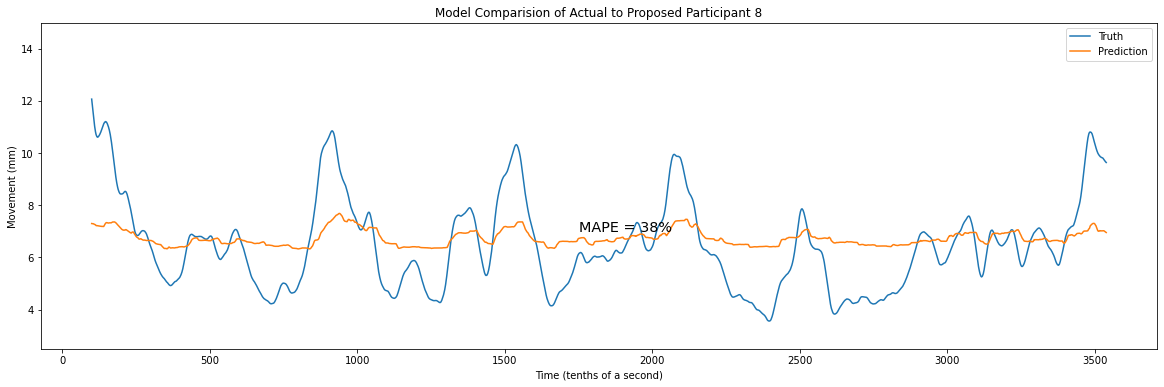

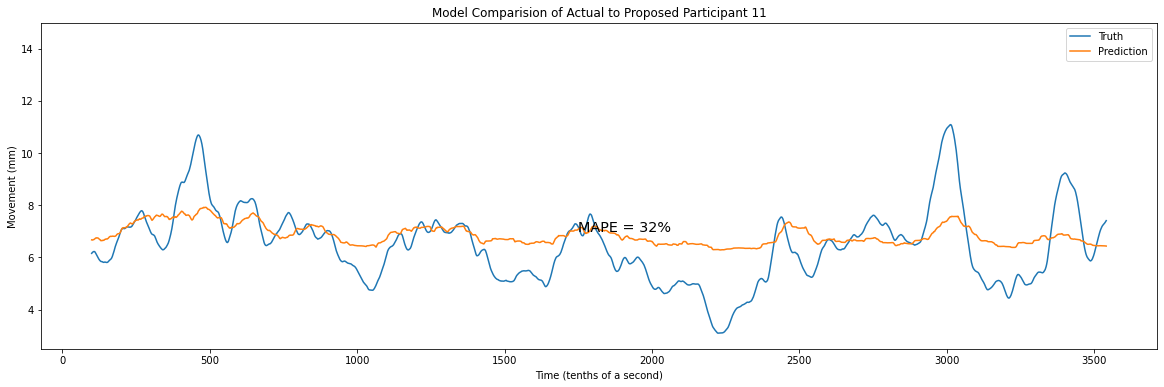

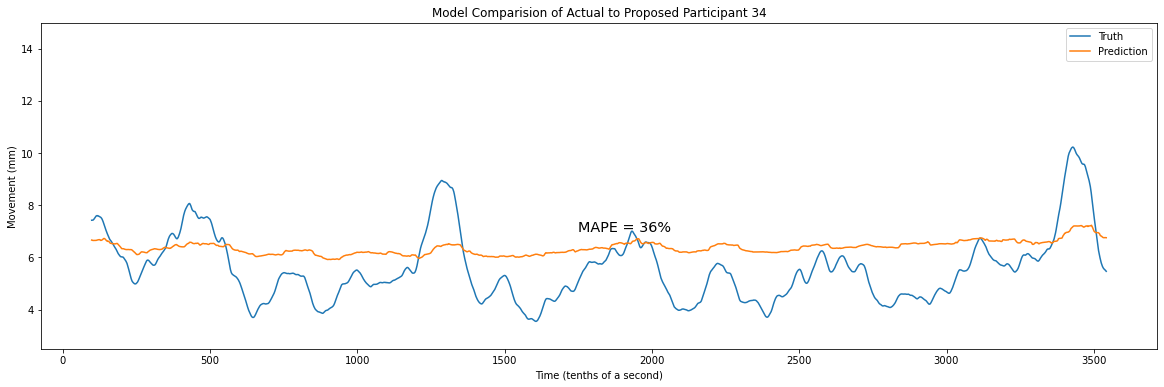

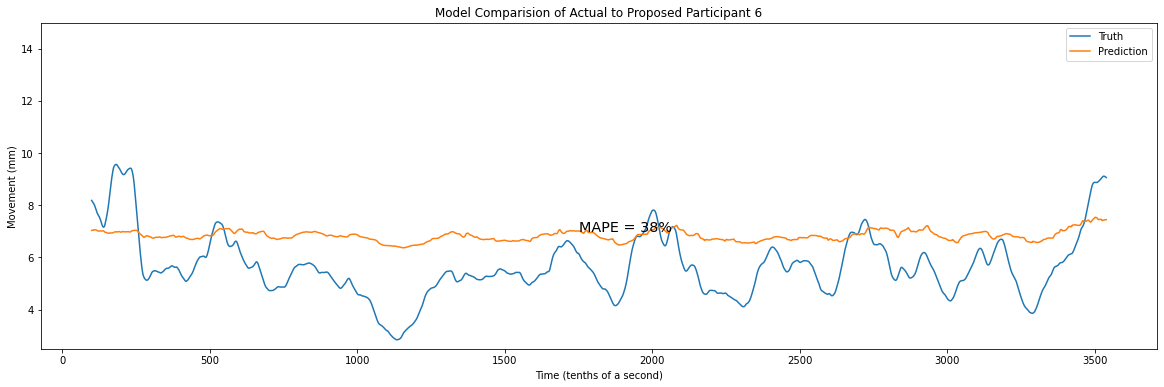

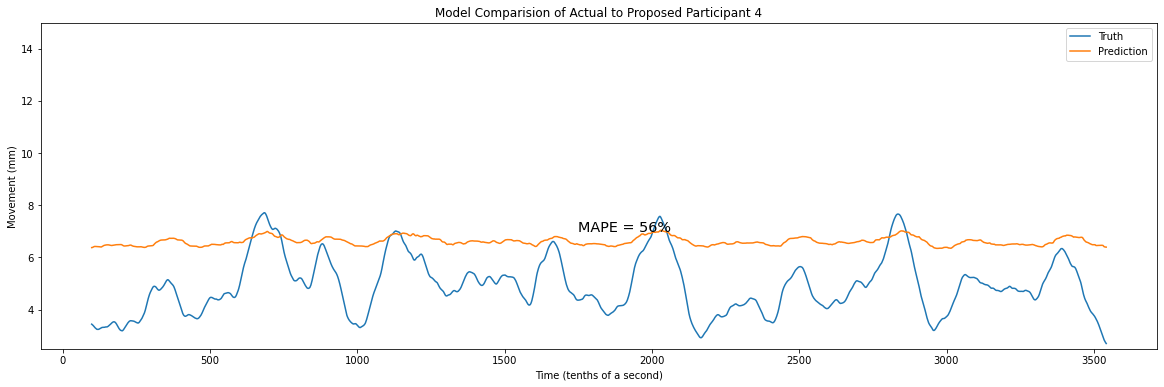

In [11]:
#visualize predictions and truths
results, ada_scores = score_model(ada, participants=participants, test_y=test_y, test_X=test_X_pca50, 
                      model_name='ADA', log = ada_scores)
plot_predictions(results, participants)

Not bad for a first attempt. Very smooth and does't follow the amplitude, but it does show that is is sensitive to the trend. Let's increase our learning rate.

# ADA Regressor LR = 5

In [12]:
#create and fit model
ada_lr5 = AdaBoostRegressor(learning_rate=5)
with joblib.parallel_backend('dask'):
    ada_lr5.fit(train_X_pca50, train_y) 

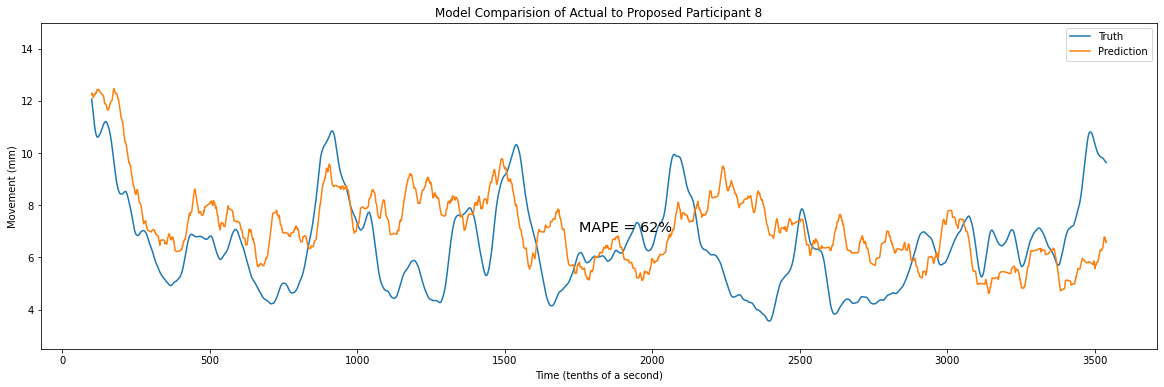

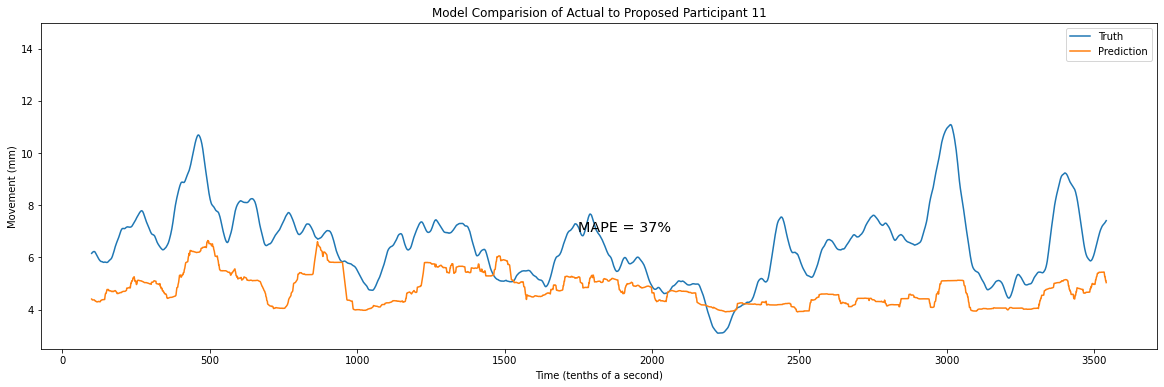

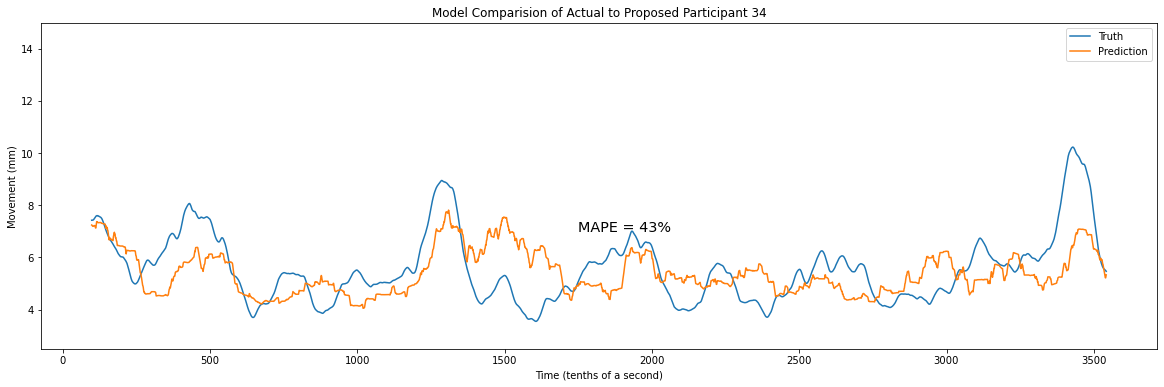

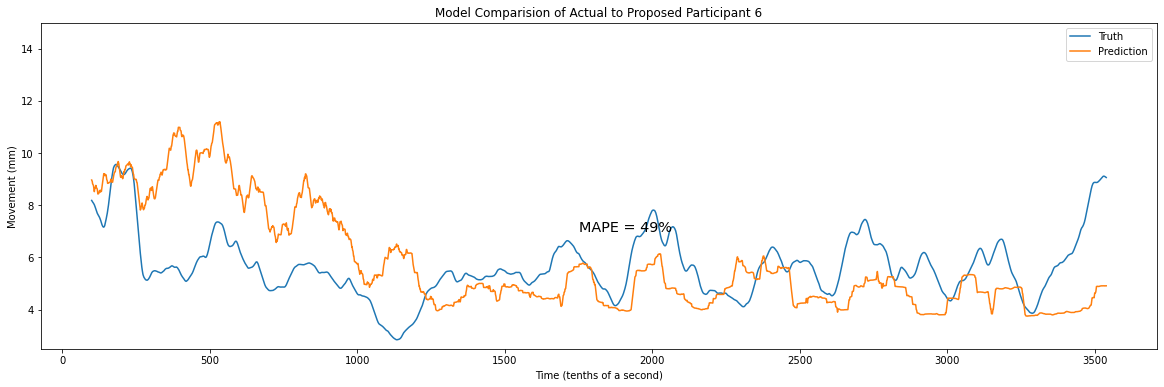

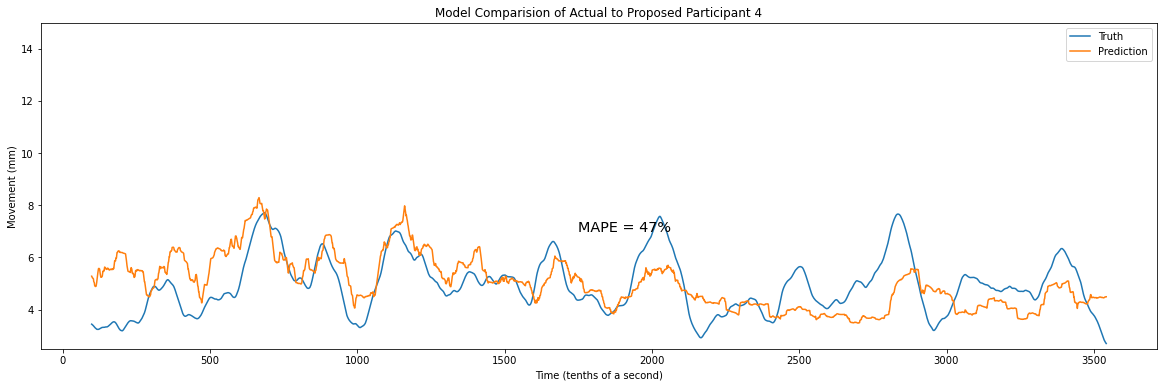

In [13]:
#Visulaize predictions and truths
results, ada_scores = score_model(ada_lr5, participants=participants, test_y=test_y, test_X=test_X_pca50, 
                      model_name='ADA_lr5', log = ada_scores)
plot_predictions(results, participants)

While at times it looks like a better predictor of amplitude, it is note consistent enough to say. I think we over stepped on the high side, let's reduce the learning rate to 0.2 and see if we can get back on track.

# ADA Regressor LR = 0.2

In [14]:
#create model and fit
ada_lr02 = AdaBoostRegressor(learning_rate=0.2)
with joblib.parallel_backend('dask'):
    ada_lr02.fit(train_X_pca50, train_y) 

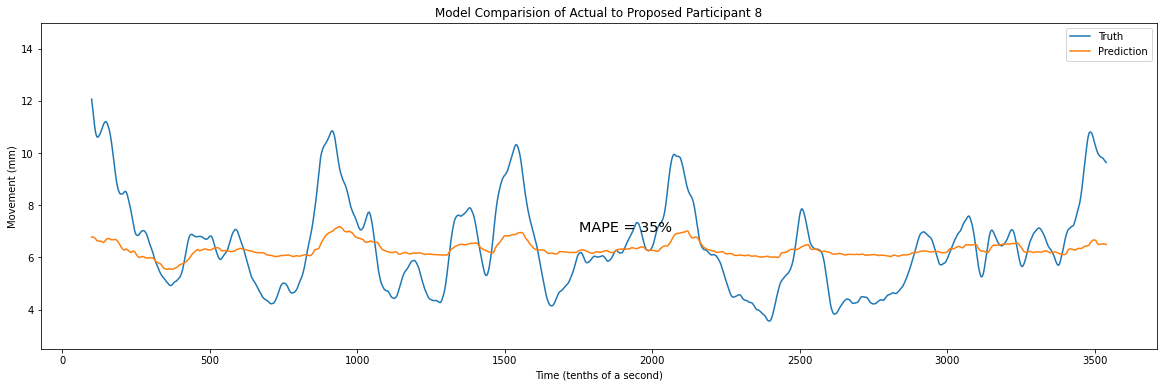

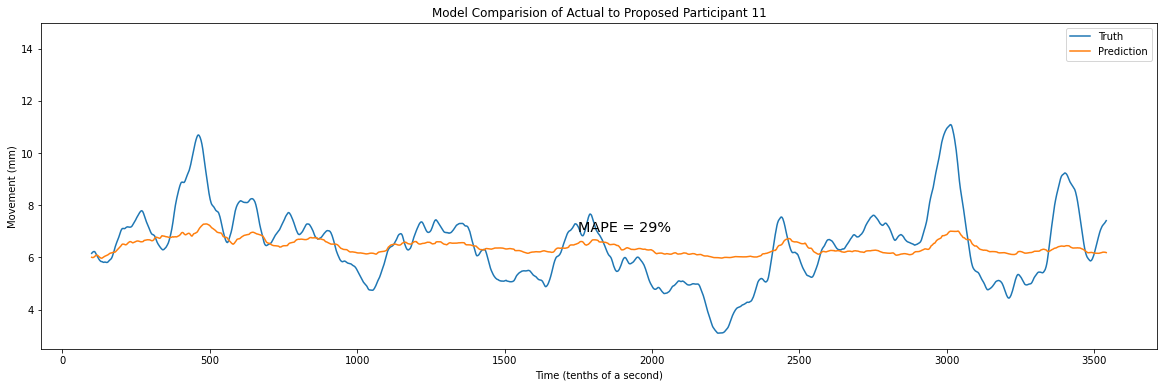

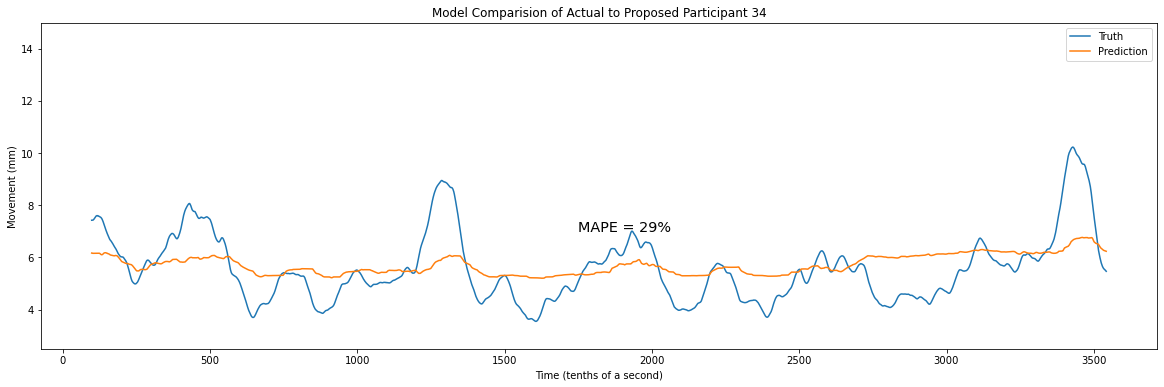

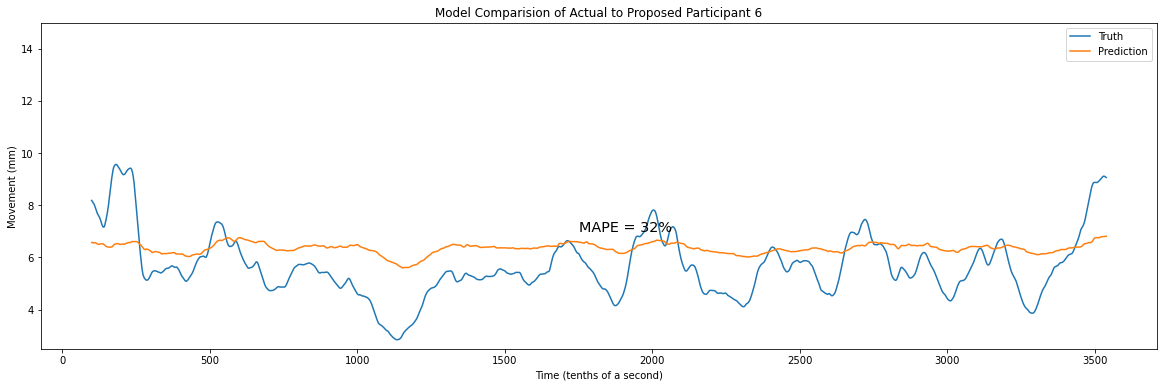

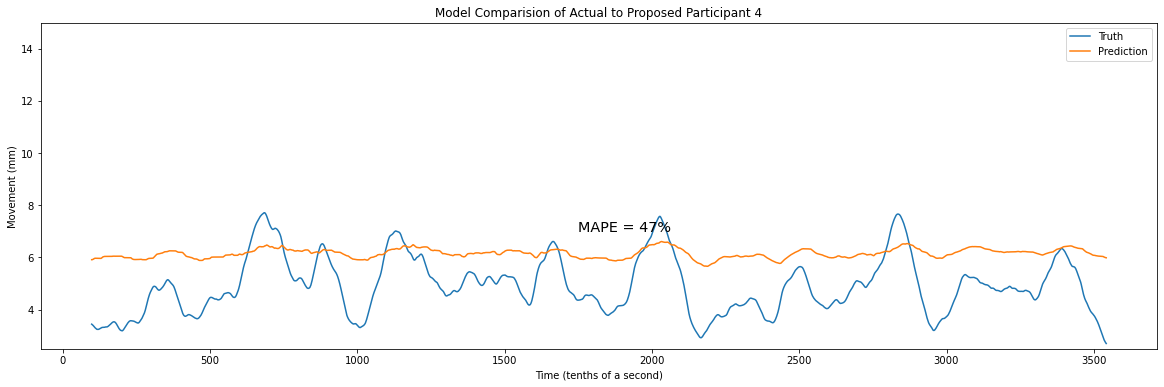

In [15]:
#Visualize predictions and truths
results, ada_scores = score_model(ada_lr02, participants=participants, test_y=test_y, test_X=test_X_pca50, 
                      model_name='ADA_lr0.2', log = ada_scores)
plot_predictions(results, participants)

We definitely perfomr better from a MAPE, MAE perspective, mostly because we follow the mean more closely. This is definitely an improvement, but with room for more. Let's try using a linear model. We will use our XGB model as a base estimator 

# ADA Regressor LR = 0.5, XGB

In [16]:
#create and fit model
xgblin05 = XGBRegressor(n_estimators=250, booster='gblinear')
ada_lin05 = AdaBoostRegressor(xgblin05, learning_rate=0.5)
with joblib.parallel_backend('dask'):
    ada_lin05.fit(train_X_pca50, train_y) 

In [17]:
#add linear parameters to log dictionary
for param in ada_lin05.get_params():
    if param not in ada_scores.keys():
        ada_scores[param]=[]

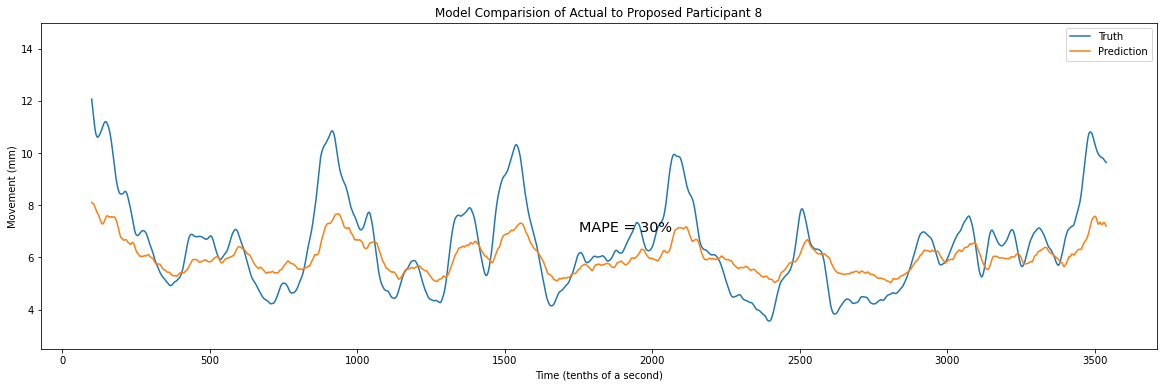

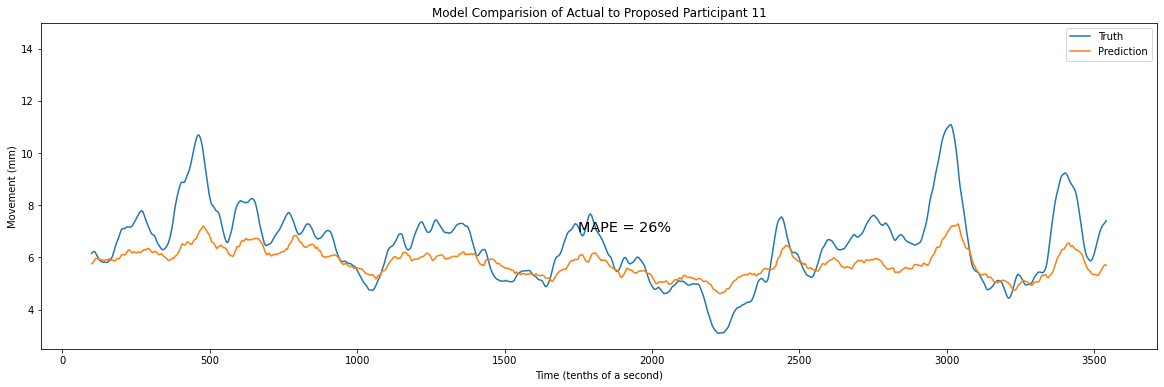

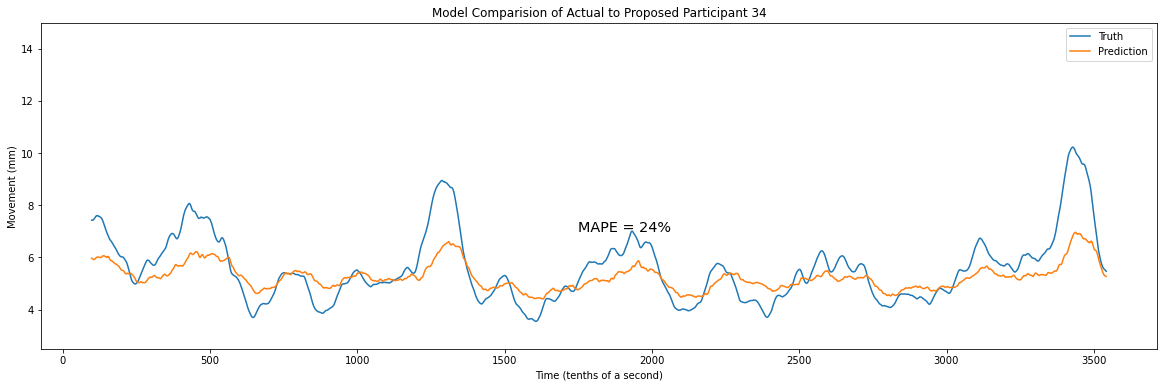

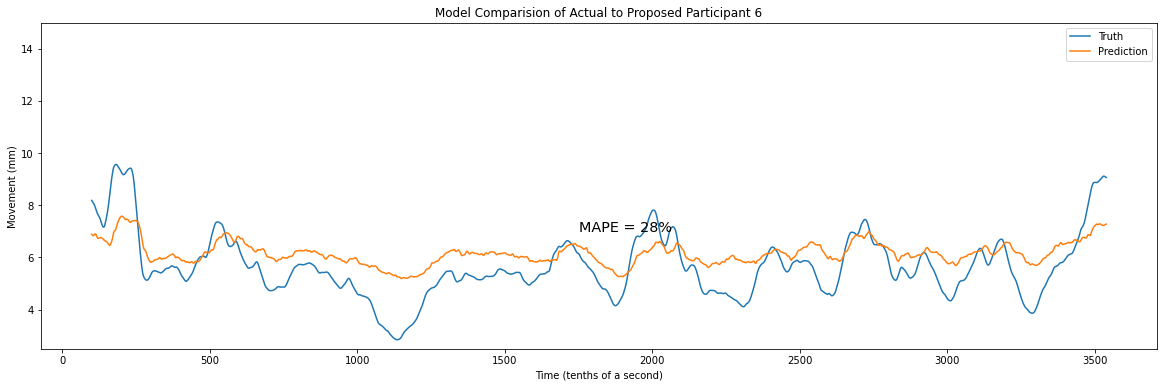

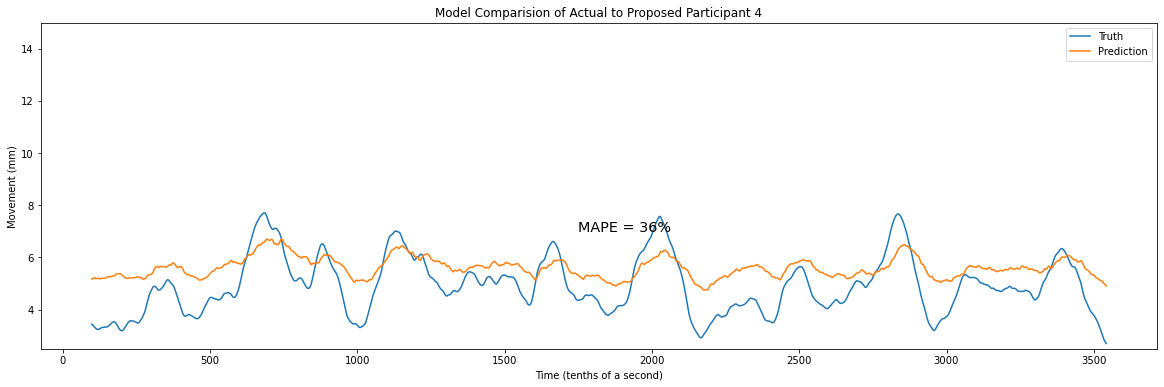

In [18]:
#Visualize predictions and truths
results, ada_scores = score_model(ada_lin05, participants=participants, test_y=test_y, test_X=test_X_pca50, 
                      model_name='ADA_LIN05', log = ada_scores)
plot_predictions(results, participants)

In [19]:
#Adjust dictionary for base estiamtor keys
for index in range(1,6):
    ada_scores['base_estimator'][-1*index] = 'XGBRegressor'
ada_scores['base_estimator']

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 'XGBRegressor',
 'XGBRegressor',
 'XGBRegressor',
 'XGBRegressor',
 'XGBRegressor']

In [20]:
#Adjust dictionary for base estiamtor keys
for param in list(ada_scores.keys()):
    if param.__contains__('base_estimator__'):
         for index in range(1,16):
            ada_scores[param].insert(0,np.nan)

In [21]:
#convert metrics dictionary to dataframe
ada_df = pd.DataFrame(ada_scores)
ada_df.groupby(['par','model']).mean()

MAPE       MAE  learning_rate  n_estimators  \
par model                                                        
4   ADA        0.560456  2.062652            1.0            50   
    ADA_LIN05  0.360512  1.402540            0.5            50   
    ADA_lr0.2  0.475512  1.765284            0.2            50   
    ADA_lr5    0.477534  2.174672            5.0            50   
6   ADA        0.386063  1.798488            1.0            50   
    ADA_LIN05  0.285261  1.415217            0.5            50   
    ADA_lr0.2  0.322184  1.543693            0.2            50   
    ADA_lr5    0.492273  2.784711            5.0            50   
8   ADA        0.386962  2.106786            1.0            50   
    ADA_LIN05  0.302080  1.877702            0.5            50   
    ADA_lr0.2  0.358875  2.079701            0.2            50   
    ADA_lr5    0.626544  3.540227            5.0            50   
11  ADA        0.323358  1.750690            1.0            50   
    ADA_LIN05  0.260244  1.670959            0.5            50   
    ADA_lr0.2  0.295138  1.693294            0.2            50   
    ADA_lr5    0.376432  2.648220            5.0            50   
34  ADA        0.360083  1.650912            1.0            50   
    ADA_LIN05  0.244721  1.342496            0.5            50   
    ADA_lr0.2  0.290144  1.446115            0.2            50   
    ADA_lr5    0.435393  2.365394            5.0            50   

               base_estimator__base_score  base_estimator__colsample_bylevel  \
par model                                                                      
4   ADA                               NaN                                NaN   
    ADA_LIN05                         NaN                                NaN   
    ADA_lr0.2                         NaN                                NaN   
    ADA_lr5                           NaN                                NaN   
6   ADA                               NaN                                NaN   
    ADA_LIN05                         NaN                                NaN   
    ADA_lr0.2                         NaN                                NaN   
    ADA_lr5                           NaN                                NaN   
8   ADA                               NaN                                NaN   
    ADA_LIN05                         NaN                                NaN   
    ADA_lr0.2                         NaN                                NaN   
    ADA_lr5                           NaN                                NaN   
11  ADA                               NaN                                NaN   
    ADA_LIN05                         NaN                                NaN   
    ADA_lr0.2                         NaN                                NaN   
    ADA_lr5                           NaN                                NaN   
34  ADA                               NaN                                NaN   
    ADA_LIN05                         NaN                                NaN   
    ADA_lr0.2                         NaN                                NaN   
    ADA_lr5                           NaN                                NaN   

               base_estimator__colsample_bynode  \
par model                                         
4   ADA                                     NaN   
    ADA_LIN05                               NaN   
    ADA_lr0.2                               NaN   
    ADA_lr5                                 NaN   
6   ADA                                     NaN   
    ADA_LIN05                               NaN   
    ADA_lr0.2                               NaN   
    ADA_lr5                                 NaN   
8   ADA                                     NaN   
    ADA_LIN05                               NaN   
    ADA_lr0.2                               NaN   
    ADA_lr5                                 NaN   
11  ADA                                     NaN   
    ADA_LIN05                           

In [22]:
#view metrics by model
ada_df.groupby(['model']).mean()

,par,MAPE,MAE,learning_rate,n_estimators,base_estimator__base_score,base_estimator__colsample_bylevel,base_estimator__colsample_bynode,base_estimator__colsample_bytree,base_estimator__gamma,...,base_estimator__n_jobs,base_estimator__num_parallel_tree,base_estimator__random_state,base_estimator__reg_alpha,base_estimator__reg_lambda,base_estimator__scale_pos_weight,base_estimator__subsample,base_estimator__tree_method,base_estimator__validate_parameters,base_estimator__verbosity
model,,,,,,,,,,,,,,,,,,,,,
ADA,12.6,0.403384,1.873906,1.0,50.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ADA_LIN05,12.6,0.290564,1.541783,0.5,50.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ADA_lr0.2,12.6,0.348371,1.705617,0.2,50.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ADA_lr5,12.6,0.481635,2.702645,5.0,50.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
#Output for comparison
ada_df.to_pickle(r'DFs/scores/ada.pkl')